In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import itertools
import math

species_color = {'Marmoset': "orange",
 'Human': "green",
 'Rhesus': "blue",
 'Chimpanzee': "red",
 'Capuchin': "brown"}

PYTHON_PATH = "/Users/rb4174/Documents/projects/brain_dev_primates/altricial_brain_vocal_learning"

def condition(column,low_percentil,high_percentil):
    result_min = all(a >= b for a, b in zip(column, low_percentil))
    result_max = all(a <= b for a, b in zip(column, high_percentil))

    if result_min and result_max:
        return True
    else:
        return False
         

/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_17651/3814601429.py:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
df_fits = pd.read_pickle("{0}/data/derivatives_with_error.pkl".format(PYTHON_PATH)) 
df_events = pd.read_excel("{0}/data/developmental_stages_events.xlsx".format(PYTHON_PATH),index_col=False)
species_list = ["Chimpanzee","Rhesus","Human","Marmoset"]

Chimpanzee
Rhesus
Human
Marmoset


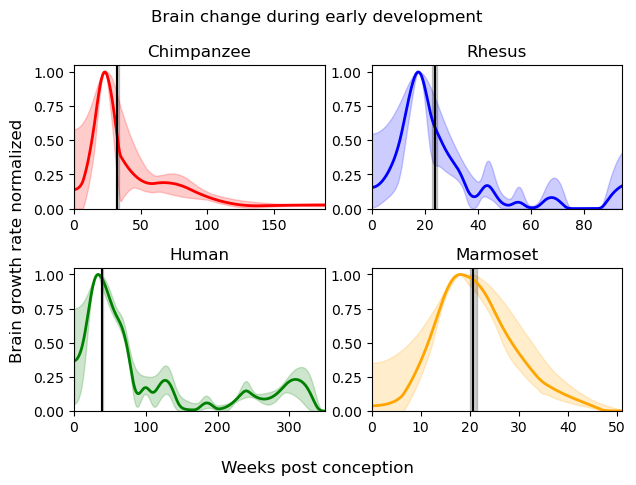

In [3]:
i = 0
derivative_data_species_all = {}
derivative_data_species_all_filtered = {}

derivative_fit = []
fig, ax = plt.subplots(nrows=2, ncols=2)

for row in ax:
    for col in row:
        specie = species_list[i]
        print(specie)
        df_fits_specie = df_fits[df_fits.specie == specie]
        df_event_specie = df_events[df_events.specie == specie]
        gestation_weeks = df_event_specie[df_event_specie.event == "gestation"]["avg_wkspc"].values[0]
        gestation_weeks_sd = df_event_specie[df_event_specie.event == "gestation"]["sd_(days)"].values[0]/7
        late_infancy_ends = df_event_specie[(df_event_specie.event == "dental_late_infancy_ends")]["avg_wkspc"].values[0]

        x = df_fits_specie["x_dydx"].item()
        y = df_fits_specie["y_dydx"].item()
        low_percentil = df_fits_specie["y_dydx_low_95Percentil"].item()
        high_percentil = df_fits_specie["y_dydx_max_95Percentil"].item()

        #Defining the distribution of rates in the birth interval, USING ALL
        df_derivative_all = {"weeks":x,"low_percentil":low_percentil,"high_percentil":high_percentil}
        for num, item in enumerate(df_fits_specie["all_y"].item()):
            df_derivative_all[num] = df_fits_specie["all_y"].item()[num]
            
        df_derivative_all = pd.DataFrame(df_derivative_all)
        derivative_data_species_all[specie] = df_derivative_all[(df_derivative_all.weeks >= gestation_weeks - gestation_weeks_sd) & 
                                                        (df_derivative_all.weeks <= gestation_weeks + gestation_weeks_sd)]

        #Plot
        SIGMA = {'Marmoset': 1,'Human': 10,'Rhesus': 10, 'Chimpanzee': 1}

        y = gaussian_filter1d(y,sigma = SIGMA[specie])
        low_percentil = gaussian_filter1d(low_percentil,sigma = SIGMA[specie])
        high_percentil = gaussian_filter1d(high_percentil,sigma = SIGMA[specie])

        y = y/np.max(y)
        low_percentil = low_percentil/np.max(low_percentil)
        high_percentil = high_percentil/np.max(high_percentil)

        col.plot(x,y, '-', color = species_color[specie],linewidth = 2)
        col.fill_between(x, low_percentil, high_percentil, color=species_color[specie], alpha=0.2)

        col.axvline(x = gestation_weeks, color = "black",linestyle = '-')
        col.axvspan(gestation_weeks - gestation_weeks_sd, gestation_weeks + gestation_weeks_sd, alpha=0.2, color='black')
        
        xlim = late_infancy_ends
        if specie == "Marmoset":
            xlim = 50
        col.set_xlim(0,xlim + 1)
        col.set_title(specie)
        col.set_ylim(bottom=0)
        i += 1

fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain growth rate normalized')
fig.suptitle("Brain change during early development")
fig.tight_layout()
fig.savefig("{0}/figs/2B.pdf".format(PYTHON_PATH),dpi = 800)
plt.show()

/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_17651/1505509260.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(x="specie", y="possible_values", data=boxplot_df, width=0.3,


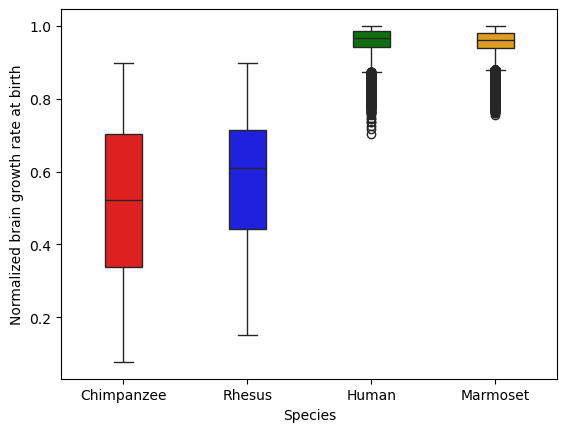

In [4]:
boxplot_df_all = {"specie":[],"possible_values":[]}
for species in df_fits["specie"].unique():
    all_values = []
    species_all_dist = derivative_data_species_all[species]
    for column in species_all_dist.columns:
        if column != "weeks":
            all_values.extend(species_all_dist[column])
    boxplot_df_all["possible_values"].extend(all_values)
    boxplot_df_all["specie"].extend(len(all_values)*[species])

boxplot_df = pd.DataFrame(boxplot_df_all)

g = sns.boxplot(x="specie", y="possible_values", data=boxplot_df, width=0.3, 
            order = ["Chimpanzee","Rhesus","Human","Marmoset"],
            palette=["red","blue","green","orange"])

g.set_xlabel("Species")
g.set_ylabel("Normalized brain growth rate at birth")
plt.savefig("{0}/figs/2C.pdf".format(PYTHON_PATH),dpi = 800)


## Calculating confidence interval of the mean of the distributions

103545
Chimpanzee
0.04280457115539921
0.8059880077214252 0.22668857059212005
Mean: 0.5163382891567726
95% Confidence Interval: [0.51505531 0.51758725]
Median: 0.5163382891567726
Max: 0.8995164487455118
Min: 0.07748634172093778

142086
Rhesus
0.02537927455103475
0.8075596785535312 0.36149520733876106
Mean: 0.5845274429461461
95% Confidence Interval: [0.58372451 0.58534672]
Median: 0.5845274429461461
Max: 0.8991645515353455
Min: 0.1512652028771087

16464
Human
0.0016253060886493103
1.0119510146960224 0.89906877634556
Mean: 0.9555098955207912
95% Confidence Interval: [0.95484535 0.95609147]
Median: 0.9555098955207912
Max: 0.9987052640658858
Min: 0.704015816378237

168168
Marmoset
0.001251637318087377
1.0042523869099187 0.9051926242723823
Mean: 0.9547225055911505
95% Confidence Interval: [0.95455368 0.95488564]
Median: 0.9547225055911505
Max: 1.0
Min: 0.756110305057173



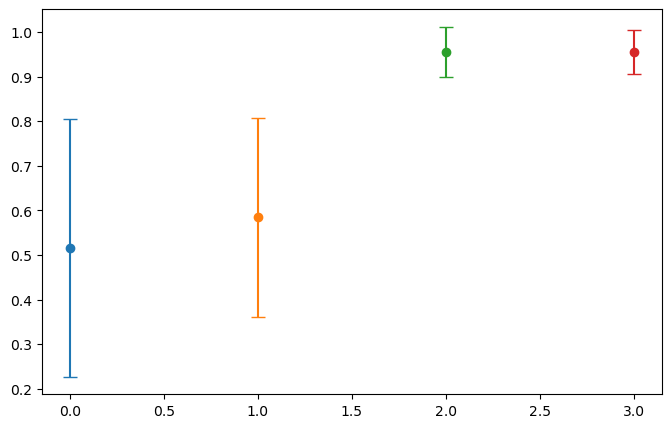

In [5]:
# Number of bootstrap samples
n_bootstrap_samples = 1000
confidence_level = 0.95

plt.figure(figsize=(8, 5))

x = 0
for species in derivative_data_species_all.keys():

    data = boxplot_df[boxplot_df.specie == species]["possible_values"]
    print(len(data))
    # Array to store bootstrap means
    bootstrap_means = np.zeros(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2
    upper_percentile = 1 - lower_percentile
    confidence_interval = np.percentile(bootstrap_means, [100 * lower_percentile, 100 * upper_percentile])

    mean = np.mean(data)
    len_data = len(data)
    median = np.median(data)
    max_value = np.max(data)
    min_value = np.min(data)

    var  = sum(pow(x-mean,2) for x in data) / len_data  # variance
    std  = math.sqrt(var)  # standard deviation

    print(species)
    print(var)
    lower_bound = std*1.4 #1.96
    upper_bound = std*1.4 #1.96
    print(mean + lower_bound,mean - upper_bound)

    plt.errorbar(x, mean, yerr=[[lower_bound], [upper_bound]], fmt='o', capsize=5, label='95% CI')
    #plt.xticks(x, species)
    x += 1
    print(f"Mean: {mean}")
    print(f"95% Confidence Interval: {confidence_interval}")
    print(f"Median: {mean}")
    print(f"Max: {max_value}")
    print(f"Min: {min_value}")


    print()

# percentil bonds of the distributions

In [6]:
percentil = 0.95

for species in derivative_data_species_all.keys():

    lower_percentile = (1 - percentil) / 2
    upper_percentile = 1 - lower_percentile
    data = boxplot_df[boxplot_df.specie == species]["possible_values"]
    confidence_interval = np.percentile(data, [100 * lower_percentile, 100 * upper_percentile])

    mean = np.mean(data)

    print(species)
    print(f"Mean: {mean}")
    print(f"95% Percentil bounds: {confidence_interval}")
    print()

Chimpanzee
Mean: 0.5163382891567726
95% Percentil bounds: [0.15391124 0.83880735]

Rhesus
Mean: 0.5845274429461461
95% Percentil bounds: [0.29174713 0.83459255]

Human
Mean: 0.9555098955207912
95% Percentil bounds: [0.83907003 0.99639639]

Marmoset
Mean: 0.9547225055911505
95% Percentil bounds: [0.85707309 0.99864588]



## ROC curve

/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_17651/2059788363.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="specie", y="possible_values", data=boxplot_df, width=0.3,


<Axes: xlabel='specie', ylabel='possible_values'>

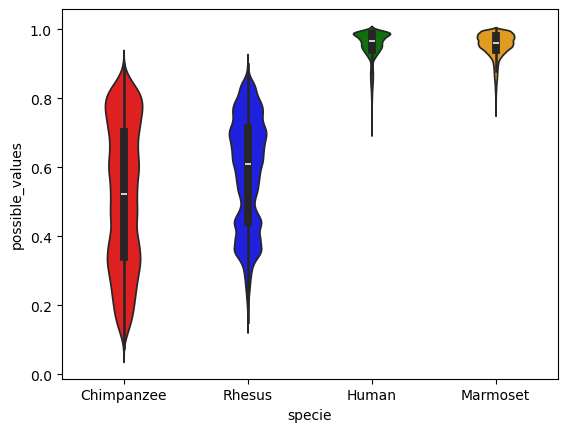

In [7]:
sns.violinplot(x="specie", y="possible_values", data=boxplot_df, width=0.3, 
            order = ["Chimpanzee","Rhesus","Human","Marmoset"],
            palette=["red","blue","green","orange"])


<Axes: xlabel='possible_values', ylabel='Count'>

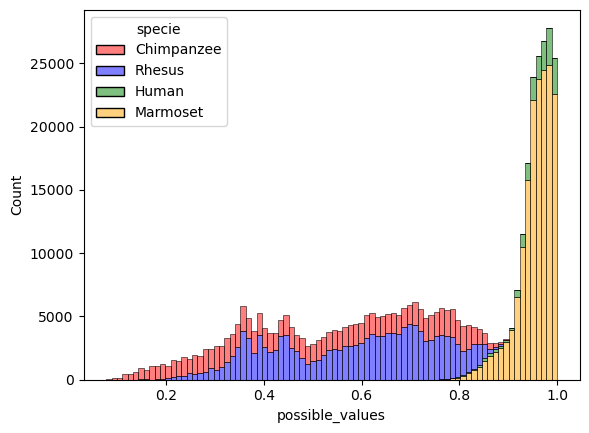

In [8]:
sns.histplot(hue="specie", x="possible_values", data=boxplot_df,multiple="stack", alpha = 0.5,
            palette=["red","blue","green","orange"])

In [9]:
df_all_box = pd.DataFrame(boxplot_df_all)
df_all_box.head()

,specie,possible_values
0,Chimpanzee,0.314723
1,Chimpanzee,0.295854
2,Chimpanzee,0.278606
3,Chimpanzee,0.262652
4,Chimpanzee,0.246837


In [10]:
#ROC calculation
list_species = ["Marmoset","Human","Rhesus","Chimpanzee"]

confusion_matrix = {"actually_altricial_predicted_altricial":[],"actually_precocial_predicted_altricial":[],
                    "actually_altricial_predicted_precocial":[],"actually_precocial_predicted_precocial":[],
                    "pair_comparison":[],"threshold":[],
                    "TPR":[], #true positive rate/recall/sensitivity or true positive/ all positive ("altricials I got right/all altricials")
                    "FPR":[], #false positive rate/ false alarm rate or false positive/ all negative ("precocials I classified as altricial/ all precocials")
                    }

for pair in [["Marmoset","Rhesus"],["Marmoset","Chimpanzee"],["Human","Rhesus"],["Human","Chimpanzee"],
             ["Human","Marmoset"],["Rhesus","Chimpanzee"]]:
    print(pair)
    for threshold in np.arange(0, 1.01, 0.01):
        confusion_matrix["threshold"].append(threshold) #if value >= threshold --> it is altricial (True)
        confusion_matrix["pair_comparison"].append("{0}_{1}".format(pair[0],pair[1]))

        altricial_species = df_all_box[df_all_box.specie == pair[0]]
        precocial_species = df_all_box[df_all_box.specie == pair[1]]

        tp = len(altricial_species[altricial_species.possible_values >= threshold])
        confusion_matrix["actually_altricial_predicted_altricial"].append(tp)

        fp = len(precocial_species[precocial_species.possible_values >= threshold])
        confusion_matrix["actually_precocial_predicted_altricial"].append(fp)

        fn = len(altricial_species[altricial_species.possible_values < threshold])
        confusion_matrix["actually_altricial_predicted_precocial"].append(fn)

        tn = len(precocial_species[precocial_species.possible_values < threshold])
        confusion_matrix["actually_precocial_predicted_precocial"].append(tn)

        confusion_matrix["TPR"].append(tp/(tp + fn))

        try:
            confusion_matrix["FPR"].append(fp/(tn + fp))
        except:
            confusion_matrix["FPR"].append(0)

        true_labels = [1]*len(altricial_species) + [0]*len(precocial_species)

confusion_matrix = pd.DataFrame(confusion_matrix)


['Marmoset', 'Rhesus']
['Marmoset', 'Chimpanzee']
['Human', 'Rhesus']
['Human', 'Chimpanzee']
['Human', 'Marmoset']
['Rhesus', 'Chimpanzee']


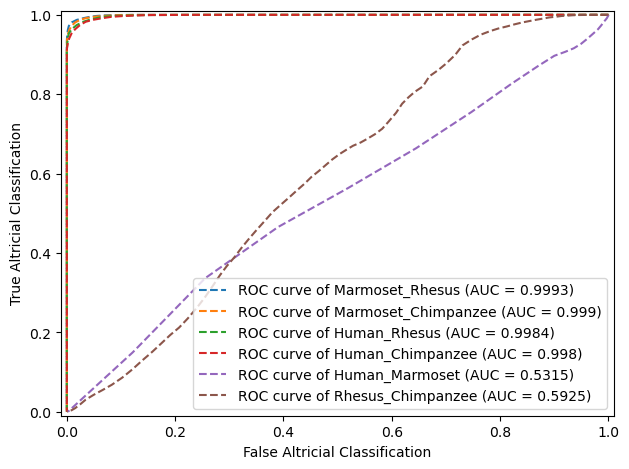

In [16]:
from sklearn.metrics import auc

for i, pair in enumerate(confusion_matrix["pair_comparison"].unique()):
    conf_matrix_pair = confusion_matrix[confusion_matrix.pair_comparison == pair]
    fpr = list(conf_matrix_pair["FPR"])
    tpr = list(conf_matrix_pair["TPR"])
    auc_value = auc(fpr,tpr)

    plt.plot(fpr, tpr,"--",label='ROC curve of {0} (AUC = {1})'.format(pair,np.round(auc_value,4)))
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.legend()
plt.xlabel("False Altricial Classification")
plt.ylabel("True Altricial Classification")
plt.tight_layout()
plt.savefig("{0}/figs/ROC_plot.pdf".format(PYTHON_PATH),dpi = 300)


Marmoset_Rhesus
Minimal threshold for true altricial class = 1: threshold:0.75, TPR=1.0, FPR=0.17258561716143744
Maximal threshold for false altricial class = 0: threshold:0.9, TPR=0.920389134674849, FPR=0.0

Marmoset_Chimpanzee
Minimal threshold for true altricial class = 1: threshold:0.75, TPR=1.0, FPR=0.1747356221932493
Maximal threshold for false altricial class = 0: threshold:0.9, TPR=0.920389134674849, FPR=0.0

Human_Rhesus
Minimal threshold for true altricial class = 1: threshold:0.7000000000000001, TPR=1.0, FPR=0.2884450262517067
Maximal threshold for false altricial class = 0: threshold:0.9, TPR=0.9068877551020408, FPR=0.0

Human_Chimpanzee
Minimal threshold for true altricial class = 1: threshold:0.7000000000000001, TPR=1.0, FPR=0.2550968178086822
Maximal threshold for false altricial class = 0: threshold:0.9, TPR=0.9068877551020408, FPR=0.0

Human_Marmoset
Minimal threshold for true altricial class = 1: threshold:0.0, TPR=1.0, FPR=1.0
Rhesus_Chimpanzee
Minimal threshold for 

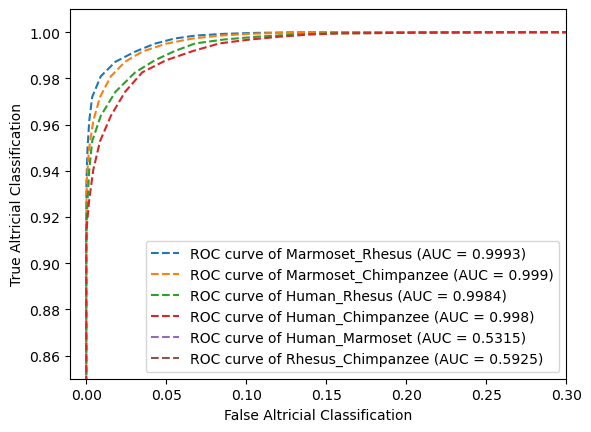

In [15]:

for i, pair in enumerate(confusion_matrix["pair_comparison"].unique()):
    conf_matrix_pair = confusion_matrix[confusion_matrix.pair_comparison == pair]
    fpr = list(conf_matrix_pair["FPR"])
    tpr = list(conf_matrix_pair["TPR"])
    auc_value = auc(fpr,tpr)
    plt.plot(fpr, tpr,"--",label='ROC curve of {0} (AUC = {1})'.format(pair,np.round(auc_value,4)))

    try:
        x = conf_matrix_pair[conf_matrix_pair.TPR == 1].sort_values("FPR")
        y = conf_matrix_pair[conf_matrix_pair.FPR == 0].sort_values("TPR")
        print(pair)
        print("Minimal threshold for true altricial class = 1: threshold:{0}, TPR={1}, FPR={2}".format(list(x["threshold"])[0],list(x["TPR"])[0],list(x["FPR"])[0]))
        print("Maximal threshold for false altricial class = 0: threshold:{0}, TPR={1}, FPR={2}".format(list(y["threshold"])[-1],list(y["TPR"])[-1],list(y["FPR"])[-1]))
        print()
    except:
        pass


plt.legend()
plt.xlim(-0.01,0.3)
plt.ylim(0.85,1.01)
plt.xlabel("False Altricial Classification")
plt.ylabel("True Altricial Classification")
plt.savefig("{0}/figs/ROC_plot_zoom.pdf".format(PYTHON_PATH),dpi = 300)

